En este código estoy haciendo pruebas con una API en el entorno de Visual con lenguaje de Python para mandar una señal al Analog Discovery sin necesidad de descargar un .csv

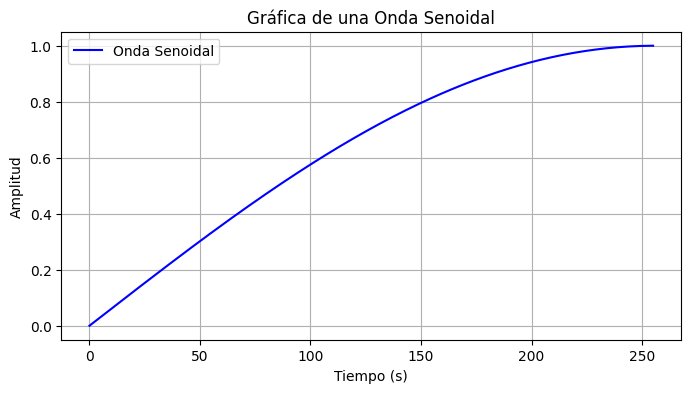

In [4]:
import math 
import numpy as np
import matplotlib.pyplot as plt

### Estoy generando una señal de pruebaaa

# Definir parámetros de la señal
frecuencia = 1  # Frecuencia en Hz
amplitud = 1    # Amplitud de la onda
tiempo = np.linspace(0, 2, 1000)  # 2 segundos con 1000 puntos

# Crear la señal seno
#onda_seno = amplitud * np.sin(2 * np.pi * frecuencia * tiempo)
waveform = [math.sin(i * 2 * math.pi / 256 / 4) for i in range(0, 256)]

# Graficar la señal
plt.figure(figsize=(8, 4))
#plt.plot(tiempo, onda_seno, label="Onda Senoidal", color="b")
plt.plot(waveform, label="Onda Senoidal", color="b")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Gráfica de una Onda Senoidal")
plt.grid(True)
plt.legend()
plt.show()


In [2]:
import dwfpy as dwf
#Señal seno
with dwf.AnalogDiscovery2() as device:
    print('Generating a 1kHz sine wave on WaveGen channel 1...')
    device.analog_output['ch1'].setup('sine', frequency=1e3, amplitude=1, start=True)
    input('Press Enter key to exit.')

Generating a 1kHz sine wave on WaveGen channel 1...


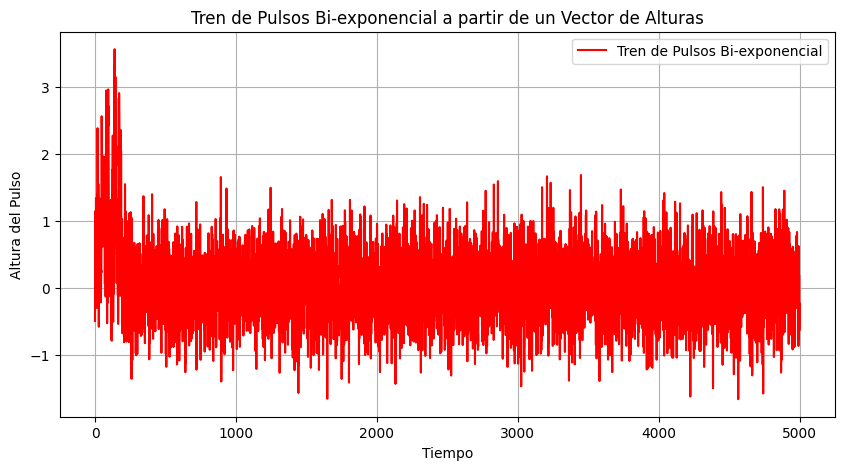

In [8]:
##Este código me genera un tren de pulsos a partir de un vector de alturas (introduciendosele ruido)
import numpy as np
import matplotlib.pyplot as plt
#Señal
def biexponential_pulse(t, t0, amplitude, tau_rise, tau_fall):
    """
    Genera un pulso de doble exponencial.
    """
    pulse = np.where(t >= t0, amplitude * (np.exp(-(t - t0) / tau_fall) - np.exp(-(t - t0) / tau_rise)), 0)
    return pulse

def generate_pulse_train(heights, pulse_width=10, spacing=5, total_time=5000, tau_rise=2, tau_fall=5, noise_level=0.5):
    """
    Genera un tren de pulsos bi-exponenciales a partir de un vector de alturas.
    """
    t = np.arange(0, total_time, 1)
    signal = np.zeros_like(t, dtype=float)

    current_position = 0
    for height in heights:
        if current_position + pulse_width < total_time:
            signal += biexponential_pulse(t, current_position, height, tau_rise, tau_fall)
            current_position += pulse_width + spacing
        else:
            break

    # Agregar ruido gaussiano
    noise = np.random.normal(0, noise_level, size=t.shape)
    signal += noise

    return t, signal

# Vector de alturas de los pulsos
pulse_heights = [2, 5, 3, 7, 4, 6, 8, 3, 5, 9, 2, 7, 4]


# Generar el tren de pulsos
t, pulse_train = generate_pulse_train(pulse_heights)

# Graficar el tren de pulsos
plt.figure(figsize=(10, 5))
plt.plot(t, pulse_train, color='r', label='Tren de Pulsos Bi-exponencial')
plt.xlabel('Tiempo')
plt.ylabel('Altura del Pulso')
plt.title('Tren de Pulsos Bi-exponencial a partir de un Vector de Alturas')
plt.legend()
plt.grid()
plt.show()

#np.savetxt('datosguardados.csv', pulse_train, delimiter=',')

In [9]:
"""
DWF Python Example

This file is part of dwfpy: https://github.com/mariusgreuel/dwfpy
"""
#s
import math
import matplotlib.pyplot as plt
import dwfpy as dwf

print(f"DWF Version: {dwf.Application.get_version()}")

with dwf.Device() as device:
    print(f"Found device: {device.name} ({device.serial_number})")

    scope = device.analog_input
    wavegen = device.analog_output

    input("Connect waveform generator to oscilloscope:\n- W1 to 1+\n- GND to 1-\nPress Enter to continue...")

    print("Generating quarter sine wave...")
    #waveform = [math.sin(i * 2 * math.pi / 256 / 4) for i in range(0, 256)]
    waveform = pulse_train
    wavegen[0].setup("custom", frequency=1e6, amplitude=1, data_samples=waveform, start=True)

    print("Starting oscilloscope...")
    scope[0].setup(range=2)
    scope.setup_edge_trigger(mode="normal", channel=0, slope="rising", level=0, hysteresis=0.01)
    recorder = scope.record(sample_rate=1e6, length=5e-3, configure=True, start=True)

    if recorder.lost_samples > 0:
        print("Samples lost, reduce sample rate.")
    if recorder.corrupted_samples > 0:
        print("Samples corrupted, reduce sample rate.")

    print(
        f"Processed {recorder.total_samples} samples total, "
        f"received {len(recorder.channels[0].data_samples)} samples."
    )

    channels = recorder.channels

for channel in channels:
    plt.plot(channel.data_samples, drawstyle="steps-post")

plt.show()

DWF Version: 3.23.4
Found device: Analog Discovery 2 (210321A95F6F)
Generating quarter sine wave...
Starting oscilloscope...


KeyboardInterrupt: 

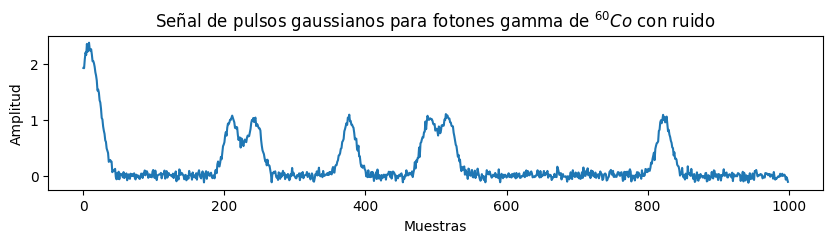

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import csv

def generate_poisson_events(lambda_bq, duration_s):
    """
    Simula tiempos de llegada de eventos siguiendo una distribución de Poisson.
    :param lambda_bq: Tasa de emisión en becquerelios (eventos por segundo)
    :param duration_s: Duración total de la simulación en segundos
    :return: Lista de tiempos de llegada de los eventos
    """
    event_times = []  #es una lista con los tiempos en los que ocurren los eventos (fotones gamma).
    t = 0
    while t < duration_s:
        t += np.random.exponential(1 / lambda_bq)  # Intervalo entre eventos
        if t < duration_s:
            event_times.append(t)
    return event_times

def generate_gaussian_pulses(event_times, sampling_rate, pulse_width, noise_level):
    """
    Genera una señal con pulsos gaussianos basada en los tiempos de llegada de eventos.
    :param event_times: Lista de tiempos de llegada de los eventos
    :param sampling_rate: Frecuencia de muestreo en Hz
    :param pulse_width: Ancho de los pulsos gaussianos en segundos
    :param noise_level: Nivel de ruido agregado a la señal
    :return: Señal con pulsos gaussianos y ruido
    """
    #Define la duracion total de la simulacion 
    duration_s = max(event_times) if event_times else 0 #  max(event_times) obtiene el tiempo del último evento para definir la duración total de la señal. y si event_times esta vacio le pone un cero par evitar errores.
    num_samples = int(duration_s * sampling_rate)  #para obtener el número total de muestras en la señal.

#Inicializar la señal y el eje de tiempo
    signal = np.zeros(num_samples)  #Creamos un array de ceros con el mismo número de muestras (num_samples), donde agregaremos los pulsos.
    time_axis = np.arange(num_samples) / sampling_rate  # Generamos un eje de tiempo con num_samples puntos, espaciados cada (1 / sampling_rate) segundos.


 #Generar los pulsos gaussianos   
    for t in event_times:  #Iteramos sobre cada t en event_times, es decir, para cada fotón gamma detectado.
        pulse =np.exp(-((time_axis - t) ** 2) / (2 * pulse_width** 2)) 
        signal += pulse          # sumamos el anterior pulso a signal, lo que permite acumular múltiples pulsos en la misma señal.
    

    #Agregar ruido gaussiano
    noise = np.random.normal(0, noise_level, num_samples)  # Genera ruido gaussiano con media 0 y desviación estándar noise_level.
    signal += noise  #agregamos el ruido a la señal
    
    return signal  # Retornar la señal con los pulsos y ruido

# Parámetros de simulación
lambda_bq = 1e6  # 1 MBq (1 millón de desintegraciones por segundo)
duration_s = 0.01  # Simulación de 10 ms,puedo cambiar el tiempo del muestreo
sampling_rate = 1e8  # 100 MHz  es la frecuencia de muestreo en Hz 1e8 por segundo
pulse_width = 1e-7  # 100 ns  pulse_width o desviacion estandar
noise_level = 0.05  # Nivel de ruido  para el ruido o desviacion estadar para el ruido

# Generar eventos
event_times = generate_poisson_events(lambda_bq, duration_s)
signal = generate_gaussian_pulses(event_times, sampling_rate, pulse_width, noise_level)

#escirtura 

## Guardar como CSV
# with open('signalsalid.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
    
#     Convertir cada elemento en una lista con un solo valor
#     writer.writerows([[value] for value in signal])

# Descargar el archivo CSV
#from google.colab import files
#files.download('signalsalid.csv')

# Visualizar resultados
plt.figure(figsize=(10, 2))
plt.plot(signal[:2000], drawstyle='default')  # Mostrar primeros 1000 puntos
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal de pulsos gaussianos para fotones gamma de $^{60}Co$ con ruido")
plt.show()

DWF Version: 3.23.4
Found device: Analog Discovery 2 (210321A95F6F)
Generating quarter sine wave...
Starting oscilloscope...
Processed 199 samples total, received 100 samples.


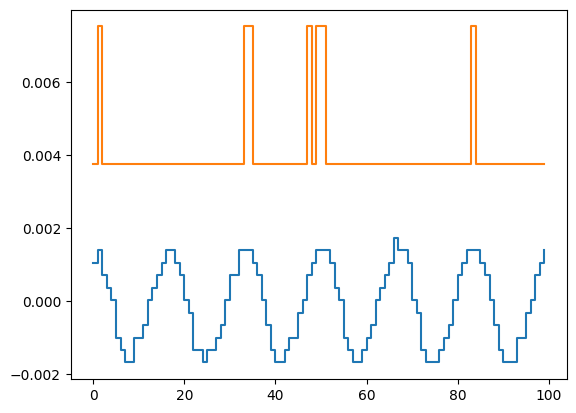

In [6]:
"""
DWF Python Example

This file is part of dwfpy: https://github.com/mariusgreuel/dwfpy
"""
#s
import math
import matplotlib.pyplot as plt
import dwfpy as dwf

print(f"DWF Version: {dwf.Application.get_version()}")

with dwf.Device() as device:
    print(f"Found device: {device.name} ({device.serial_number})")

    scope = device.analog_input
    wavegen = device.analog_output

    input("Connect waveform generator to oscilloscope:\n- W1 to 1+\n- GND to 1-\nPress Enter to continue...")

    print("Generating quarter sine wave...")
    #waveform = [math.sin(i * 2 * math.pi / 256 / 4) for i in range(0, 256)]
    waveform = signal[:1000]
    wavegen[0].setup("custom", frequency=1e3, amplitude=1, data_samples=waveform, start=True)

    print("Starting oscilloscope...")
    scope[0].setup(range=2)
    scope.setup_edge_trigger(mode="normal", channel=0, slope="rising", level=0, hysteresis=0.01)
    recorder = scope.record(sample_rate=1e3, length=100e-3, configure=True, start=True)

    if recorder.lost_samples > 0:
        print("Samples lost, reduce sample rate.")
    if recorder.corrupted_samples > 0:
        print("Samples corrupted, reduce sample rate.")

    print(
        f"Processed {recorder.total_samples} samples total, "
        f"received {len(recorder.channels[0].data_samples)} samples."
    )

    channels = recorder.channels

for channel in channels:
    plt.plot(channel.data_samples, drawstyle="steps-post")

plt.show()